# Inverse Design of a Directional Coupler (2D) with minimax and lengthscale constraints

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple


1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

minimum_length = 0.3 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

waveguide_width = 0.5 # (μm)
design_region_length = 5 + (2 * filter_radius) # (μm)
design_region_width = 2.5 + (2 * filter_radius)  # (μm)


arm_separation = 1 #design_region_width - waveguide_width - 4 * filter_radius  # (μm) distance between arms center to center
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(5 * resolution) # (pixels/μm)
nf=5
frequencies = 1/np.linspace(1.5,1.6,nf) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1


In [4]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen#1/1.5 - 1/1.6#width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,1,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]


# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


In [5]:
evaluation_history = []
cur_iter = [0]
objfunc_history=[]
epivar_history=[]

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:
    """A differentiable mapping function which applies, in order,
       the following sequence of transformations to the design weights:
       (1) a bit mask for the boundary pixels, (2) convolution with a
       conic filter, and (3) projection via a hyperbolic tangent (if
       necessary).

    Args:
      x: design weights as a 1d array of size Nx*Ny.
      eta: erosion/dilation parameter for the projection.
      beta: bias parameter for the projection. A value of 0 is no projection.

    Returns:
      The mapped design weights as a 1d array.
    """
    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)

    if beta == 0:
        return filtered_field.flatten()

    else:
        projected_field = mpa.tanh_projection(filtered_field,beta,eta)

        return projected_field.flatten()
    




def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t



def c(
    result: np.ndarray, 
    x: np.ndarray, 
    gradient: np.ndarray, 
    eta: float,
    beta: float, use_epsavg: bool):
    

    """Constraint function for the epigraph formulation.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining Nx*Ny elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                2*num. wavelengths) modified in place.
      eta: erosion/dilation parameter for projection.
      beta: bias parameter for projection.
      use_epsavg: whether to use subpixel smoothing.
    """

    print(
        "Current iteration: {}; current eta: {}, current beta: {}".format(
            cur_iter[0], eta, beta
        )
    )



    t = x[0]  # epigraph variable
    v = x[1:]  # design weights

    f0, dJ_du = opt([mapping(v, eta, 0 if use_epsavg else beta)])

    # Backprop the gradients through our mapping function
    my_grad = np.zeros(dJ_du.shape)
    for k in range(opt.nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(v, eta, beta, dJ_du[:, k])

    # Assign gradients
    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. "t"
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0) - t

    # store results
    evaluation_history.append(np.real(f0))
    epivar_history.append(t)


    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1



def glc(result: np.ndarray, x: np.ndarray, gradient: np.ndarray,
        beta: float) -> float:
    """Constraint function for the minimum linewidth.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                num. wavelengths) modified in place.
      beta: bias parameter for projection.

    Returns:
      The value of the constraint function (a scalar).
    """
    t = x[0]  # dummy parameter
    v = x[1:]  # design parameters
    a1 = 1e-4  # hyper parameter (primary)
    b1 = 1e-7  # hyper parameter (secondary)
    gradient[:, 0] = -a1

    filter_f = lambda a: mpa.conic_filter(
        a.reshape(Nx, Ny),
        0.1,
        design_region_length,
        design_region_width,
        design_region_resolution,
    )
    threshold_f = lambda a: mpa.tanh_projection(a, beta, eta_i)

    pix_len=1/design_region_resolution

    # hyper parameter (constant factor and exponent)
    c0 =  (filter_radius * 1 / pix_len) ** 4

    M1 = lambda a: mpa.constraint_solid(a, c0, eta_e, filter_f, threshold_f, 1)
    M2 = lambda a: mpa.constraint_void(a, c0, eta_d, filter_f, threshold_f, 1)

    g1 = grad(M1)(v)
    g2 = grad(M2)(v)

    result[0] = M1(v) - a1 * t - b1
    result[1] = M2(v) - a1 * t - b1

    gradient[0, 1:] = g1.flatten()
    gradient[1, 1:] = g2.flatten()

    t1 = (M1(v) - b1) / a1
    t2 = (M2(v) - b1) / a1

    print(f"glc:, {result[0]}, {result[1]}, {t1}, {t2}")

    return max(t1, t2)





def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data


def dc_optimization(
        input_flux: np.ndarray,
        input_flux_data: NamedTuple,
        use_damping: bool = False,
        use_epsavg: bool = False,
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        # weights=np.ones((Nx, Ny)),
        # beta=beta if use_epsavg else 0,
        # do_averaging = True if use_epsavg else False,
        # damping=0.02 * 2 * np.pi * fcen if use_damping else 0,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]



    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1,
                        amplitude=1.0),
                mp.EigenModeSource(
                        src,
                        eig_band=1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size=source_size,
                        center=source_center2,
                        amplitude=0.0 - 1.0j
        )]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE0 = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 0.4, y=arm_separation/2),
                size=source_size),mode,)
    # TE_top = mpa.EigenmodeCoefficient(sim,
    #         mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,arm_separation/2,0),
    #             size=source_size),mode, forward=False, subtracted_dft_fields=input_flux_data,)
    # TE_bottom = mpa.EigenmodeCoefficient(sim,
    #         mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,-arm_separation/2,0),
    #             size=source_size),mode, forward=False,  subtracted_dft_fields=input_flux_data,)
    
    ob_list = [TE0] #[TE0,TE_top,TE_bottom]


    # def J_ref_top(output,top_monitor,bottom_monitor):
    #     power = npa.abs(top_monitor) ** 2 / input_flux
    #     return power

    # def J_ref_bot(output,top_monitor,bottom_monitor):
    #     power = npa.abs(bottom_monitor) ** 2 / input_flux
    #     return power 

    def J_trans(output):
        power = npa.abs(output) ** 2 / (2 * input_flux) 
        return 1-power #minimize

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = [J_trans ],#, J_ref_top, J_ref_bot], # i dont think the order matters here its just the list of objective functions
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt




In [6]:
Nx,Ny

(561, 311)

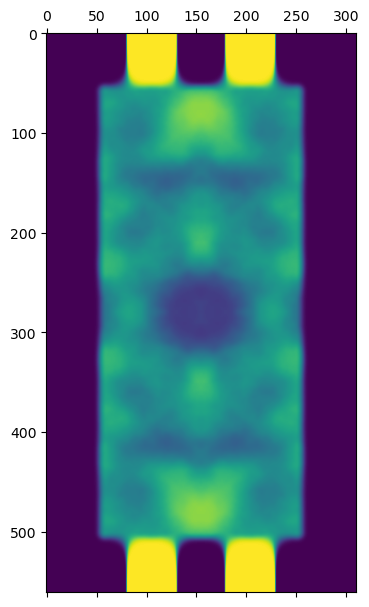

In [7]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,64).reshape(Nx,Ny))

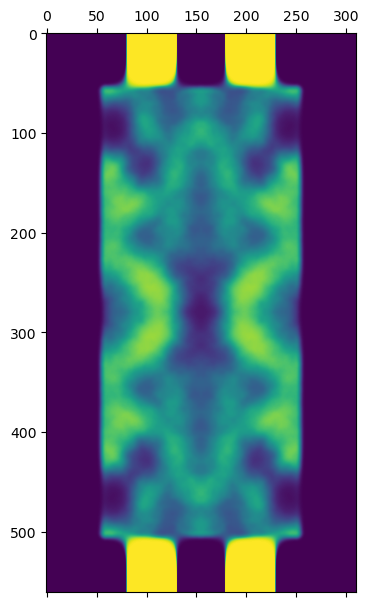

In [8]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,128).reshape(Nx,Ny))

In [9]:
input_flux, input_flux_data = straight_waveguide()

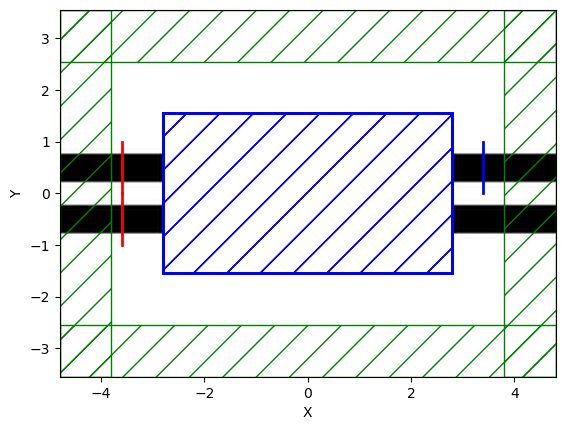

In [10]:
op=dc_optimization(input_flux,input_flux_data, beta=64)
op.plot2D(True)

## Gradient visualization

In [11]:
# x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

# #just for the same of a boundary value
# x0=np.where(x0>1,1,x0)
# x0=np.where(x0<0,0,x0)

# #x0 = np.random.rand(Nx,Ny)
# f0, g0 = op([mapping(x0,0.5,2)])

In [12]:
# np.shape(g0.T)

In [13]:
# plt.figure()
# print(g0.shape)
# plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
# plt.colorbar()

In [14]:
# backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
# plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
# plt.colorbar()

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/geom.py:582: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting forward run...
Current iteration: 0; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


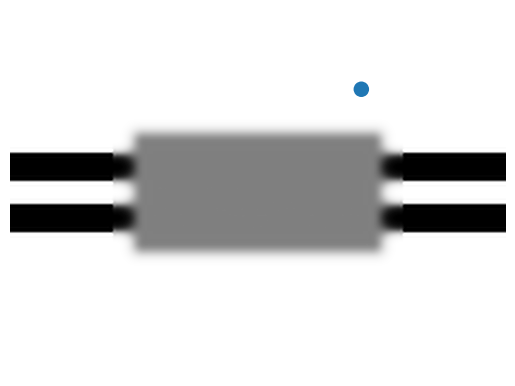

Current iteration: 1; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


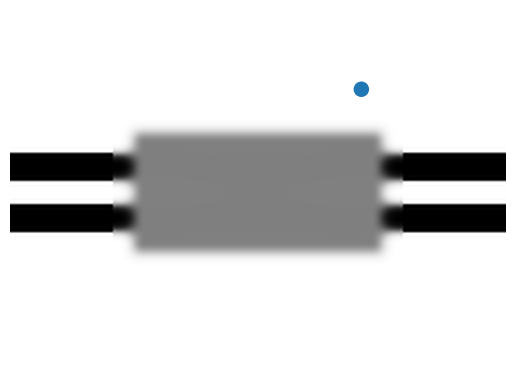

Current iteration: 2; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


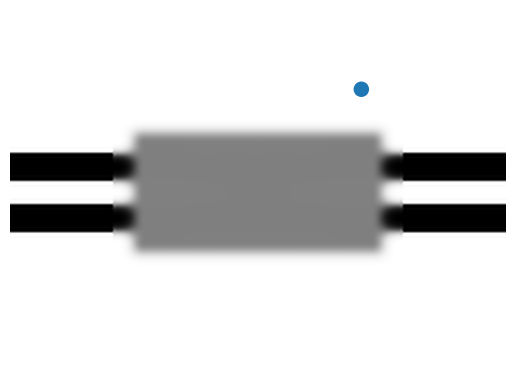

Current iteration: 3; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


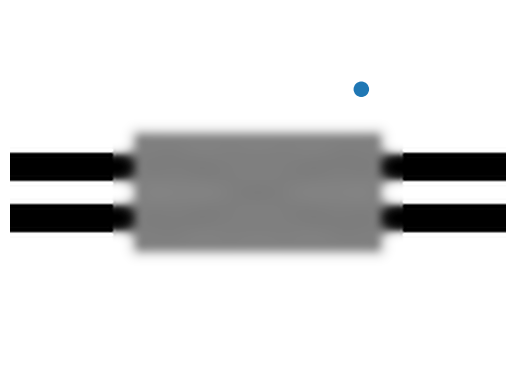

Current iteration: 4; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


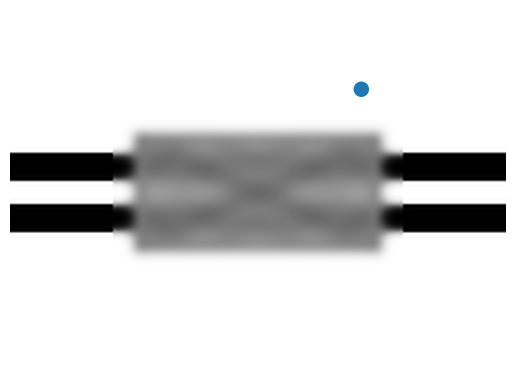

Current iteration: 5; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


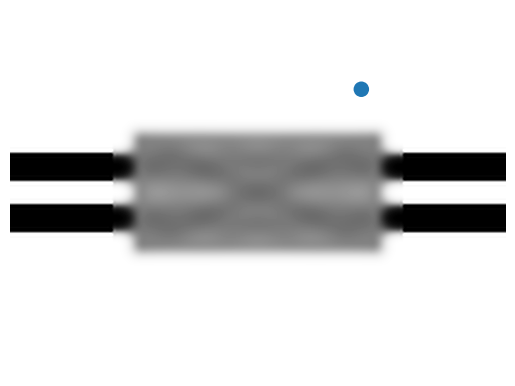

Current iteration: 6; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


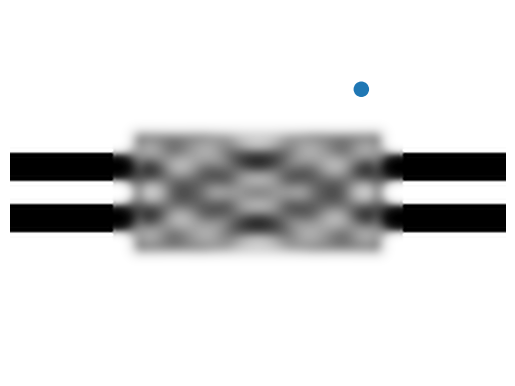

Current iteration: 7; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


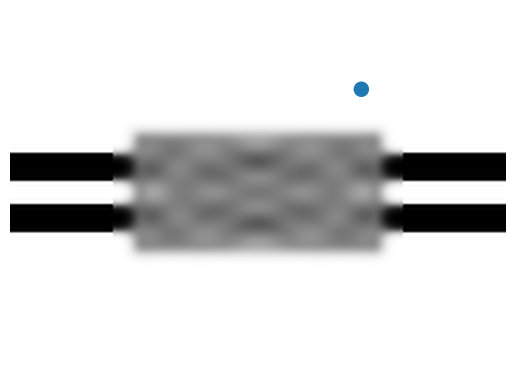

Current iteration: 8; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


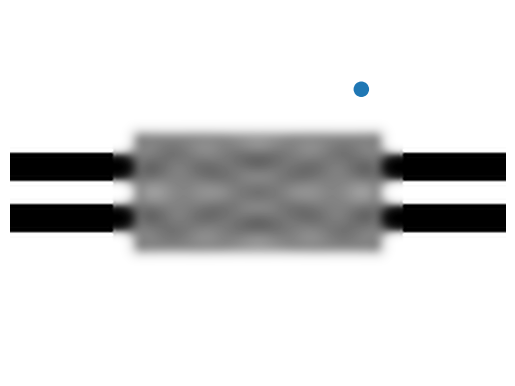

Current iteration: 9; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


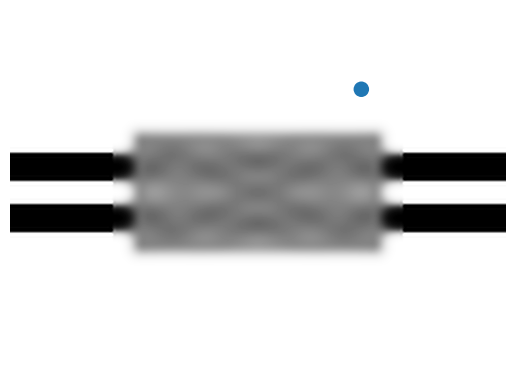

Current iteration: 10; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


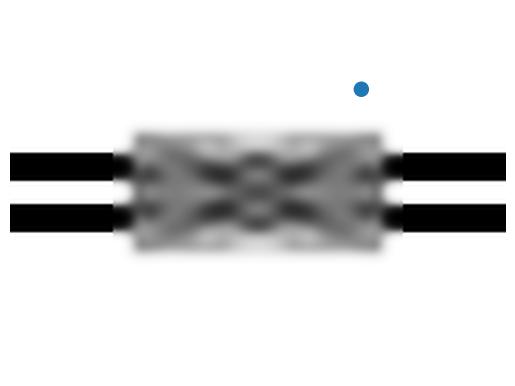

Current iteration: 11; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


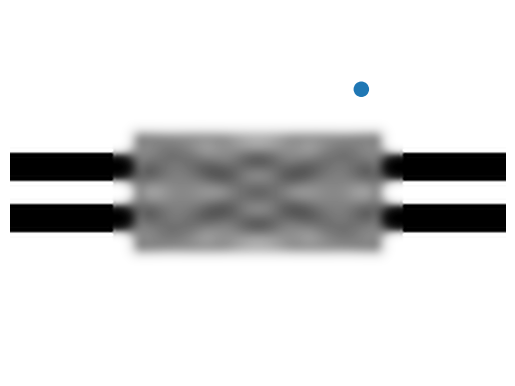

Current iteration: 12; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


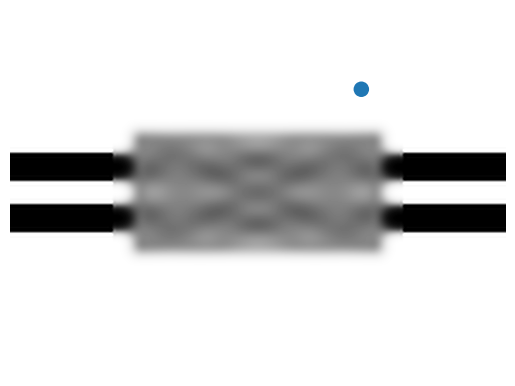

Current iteration: 13; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


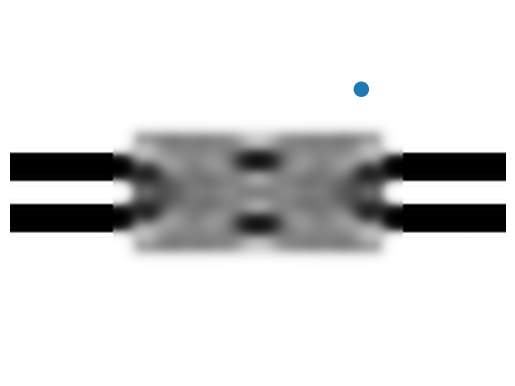

Current iteration: 14; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


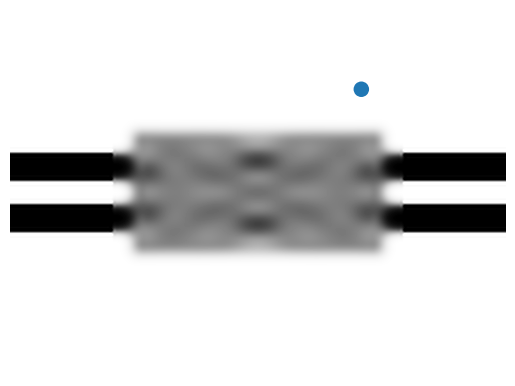

Current iteration: 15; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


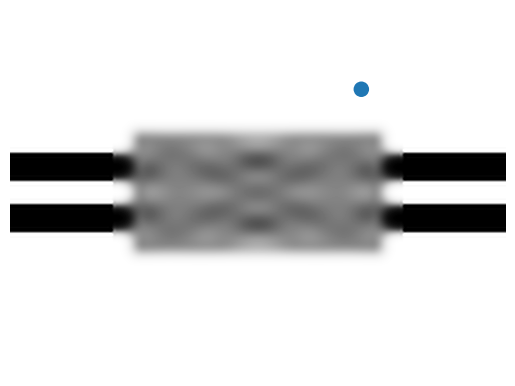

Current iteration: 16; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


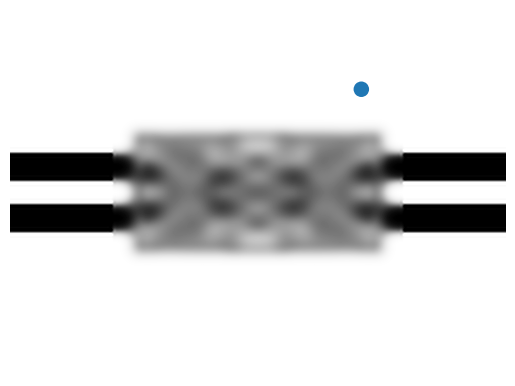

Current iteration: 17; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


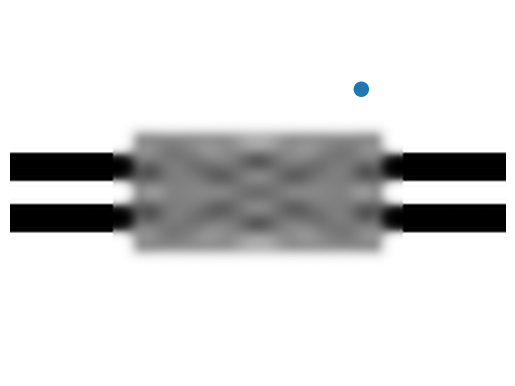

Current iteration: 18; current eta: 0.5, current beta: 4
Starting forward run...


In [15]:
input_flux, input_flux_data = straight_waveguide()

algorithm = nlopt.LD_MMA

n = Nx * Ny

mean = 0.0
std=0.2

# initial design parameters
x = np.ones((n,)) * 0.5 #+ np.random.normal(loc=mean, scale=std, size=(n,))


x[Si_mask.flatten()] = 1.0  # set the edges of waveguides to silicon
x[Air_mask.flatten()] = 0.0  # set the other edges to SiO2

# lower and upper bounds for design weights
lb = np.zeros((n,))
lb[Si_mask.flatten()] = 1.0
ub = np.ones((n,))
ub[Air_mask.flatten()] = 0.0

# insert epigraph variable initial value (arbitrary) and bounds into the
# design array. the actual value is determined by the objective and
# constraint functions below.
x = np.insert(x, 0, 1.2)
lb = np.insert(lb, 0, -np.inf)
ub = np.insert(ub, 0, +np.inf)

objfunc_history = []
epivar_history = []
cur_iter = [0]





###################### to remove subpixel smoothing, just make beta_thresh very large so that the condition never staisfies

beta_thresh = 1000000000 # threshold beta above which to use subpixel smoothing...intentionally kep very high to avoig subpixel smoothing








# betas = [8, 16, 32, 64, 128, 256, 512]
# max_evals = [80, 80, 80, 100, 100, 100, 100]
betas = [4, 8, 16, 32, 64]
max_evals = [25,25, 25, 25,100]

tol_epi = np.array([1e-4] * 1 * len(frequencies))  # R_top, R_bot, 1-T...1 when only trans
tol_lw = np.array([1e-8] *2 )  # line width, line spacing

input_flux, input_flux_data = straight_waveguide()

for beta, max_eval in zip(betas, max_evals):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(max_eval)
    solver.set_param("dual_ftol_rel", 1e-7)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            eta_i,
            beta,
            False if beta < beta_thresh else True, # use_epsavg
            
        ),
        tol_epi,
    )


    opt = dc_optimization(
        input_flux, 
        input_flux_data,
        True,  # use_damping
        False if beta < beta_thresh else True,  # use_epsavg
        beta,
    )
    # apply the minimum linewidth constraint
    # only in the final epoch to an initial
    # binary design from the previous epoch.
    if beta == betas[-1]:
        res = np.zeros(2)
        grd = np.zeros((2, n + 1))
        t = glc(res, x, grd, beta)
        solver.add_inequality_mconstraint(
            lambda rr, xx, gg: glc(
                rr,
                xx,
                gg,
                beta,
            ),
            tol_lw,
        )

    # execute a single forward run before the start of each
    # epoch and manually set the initial epigraph variable to
    # slightly larger than the largest value of the objective
    # function over the six wavelengths and the lengthscale
    # constraint (final epoch only).
    t0,_ = opt(
        [
            mapping(
                x[1:],
                eta_i,
                beta if beta < beta_thresh else 0,
            ),
        ],
        need_gradient=False,
    )
    #t0 = np.concatenate((t0[0], t0[1], t0[2]))
    x[0] = np.amax(t0)
    x[0] = 1.05 * (max(x[0], t) if beta == betas[-1] else x[0])

    x[:] = solver.optimize(x)


In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

#np.save("design_dc_minimax_lc2.npy",x[1:])


In [ ]:
plt.matshow(mapping(x[1:], eta_i, beta).reshape(Nx,Ny))

In [ ]:
epivar_history=np.array(epivar_history)
np.save("epivar_history_lc2.npy",epivar_history)
plt.figure()
plt.plot(epivar_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()


In [ ]:
plt.figure()
plt.plot(epivar_history[:250],'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()

In [ ]:
plt.figure()
plt.plot(epivar_history[290:350],'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()

In [ ]:
evaluation_history=np.array(evaluation_history)
np.save("evaluation_history.npy",evaluation_history)

In [ ]:
'''
Insertion loss(dB) = -10 * log(P_out / P_in)   .... remember the negative sign

evaluation_history is = 1 - (P_out / P_in)

1 - evaluation_history = (P_out / P_in)

take log of this...

THE LOWER, THE BETTER


'''

lb = 1 - np.min(evaluation_history, axis=1)
ub = 1 - np.max(evaluation_history, axis=1)
mean = 1 - np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), lb, ub, alpha=0.3
)
plt.plot(mean, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Transmitted power (Normalized)")
plt.title("no subpixel smoothing")

plt.show()

In [ ]:

plt.figure()
plt.plot(1-evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Transmitted power (Normalized)')
plt.show()


In [ ]:
'''
Insertion loss(dB) = -10 * log(P_out / P_in)   .... remember the negative sign

evaluation_history is = 1 - (P_out / P_in)

1 - evaluation_history = (P_out / P_in)

take log of this...

THE LOWER, THE BETTER


'''

lb = 1 - np.min(evaluation_history, axis=1)
ub = 1 - np.max(evaluation_history, axis=1)
mean = 1 - np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), -10 * np.log10(lb), -10 * np.log10(ub), alpha=0.3
)
plt.plot(-10 * np.log10(mean), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")
plt.show()

In [ ]:
plt.figure()
plt.plot(-10*np.log10(1-evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion Loss (dB)')
plt.show()

In [ ]:
def dc_final_design_sim(
        final_weights: complex = x[1:].reshape(Nx,Ny),
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=final_weights,
        beta=beta,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]





    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    source = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1)]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=source,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE_ref = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=-(Sx/2 - pml_size - 0.4), y=arm_separation/2),
                size=source_size),mode, forward=False)
    TE_top = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),arm_separation/2,0),
                size=source_size),mode)
    TE_bottom = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),-arm_separation/2,0),
                size=source_size),mode)
    ob_list = [TE_ref,TE_top,TE_bottom]

    def J(source,top_output,bottom_output):
        power = npa.abs(top_output/source) **2 + npa.abs(bottom_output/source) **2
        return power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = J,
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt, geometry


In [ ]:
final_sim,geometry=dc_final_design_sim(beta=betas[-1])
final_sim.plot2D(True)

In [ ]:
f0, dJ_du = final_sim([mapping(x[1:],eta_i,betas[-1])],need_gradient = False)
frequencies = final_sim.frequencies
ref_coef, top_coef, bottom_coef = final_sim.get_objective_arguments()



In [ ]:
# top_profile = np.abs(top_coef/source_coef) ** 2
# bottom_profile = np.abs(bottom_coef/source_coef) ** 2

top_profile = np.abs(top_coef) ** 2/ input_flux
bottom_profile = np.abs(bottom_coef) ** 2 / input_flux
ref_profile = np.abs(ref_coef) **2 / input_flux

In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'-o',label = 'Bottom Arm')
plt.plot(1/frequencies,(ref_profile)*100,'-o',label = 'Input arm reflected')

plt.plot(1/frequencies,(top_profile + bottom_profile)*100,'-o',label = 'Net output power (%)')

plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(top_profile + bottom_profile),'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss (dB)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(ref_profile),'-o' ,label = 'Return loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Return loss (dB)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_coef) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
final_sim.sim.change_sources(source)
final_sim.sim.run(until=500)
final_sim.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_glc_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_glc_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
